In [1]:
#pip install pyshp

# Questions to Answer 

What is the ideal density of available scooters to: • enable scooters to serve our transportation goals, • discourage scooters piling up on sidewalks, • keep it economically viable for companies to operate equitably in the city?

# Imports

In [2]:
#import libraries 
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import datetime
import pickle
import calendar
from folium.plugins import HeatMapWithTime
import seaborn as sns
import numpy as np

import gmplot


# Import May Trip Data

In [3]:
#import the CSV
may_trip_df = pd.read_csv('./Data/may_trip.csv')
may_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224969 entries, 0 to 224968
Data columns (total 16 columns):
pubTimeStamp      224969 non-null object
companyName       224969 non-null object
tripRecordNum     224969 non-null object
sumdID            224969 non-null object
tripDuration      224969 non-null float64
tripDistance      224969 non-null float64
startDate         224969 non-null object
startTime         224969 non-null object
endDate           224969 non-null object
endTime           224969 non-null object
startLatitude     224969 non-null float64
startLongitude    224969 non-null float64
endLatitude       224969 non-null float64
endLongitude      224969 non-null float64
tripRoute         224969 non-null object
create_dt         224969 non-null object
dtypes: float64(6), object(10)
memory usage: 27.5+ MB


In [4]:
may_trip_df.head(2)

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
0,2019-05-01 00:00:55.423000,Bird,BRD2134,Powered9EAJL,3.0000,958.00528,2019-05-01 00:00:00,00:00:20.460000,2019-05-01 00:00:00,00:02:52.346666,36.15710,-86.80360,36.15660,-86.80670,"[[36.157235,-86.803612],[36.157235,-86.80362],...",2019-05-02 05:30:23.780000
1,2019-05-01 00:03:33.147000,Lyft,LFT5,Powered296631,1.7156,1371.39112,2019-05-01 00:00:00,00:01:50.090000,2019-05-01 00:00:00,00:03:33.026666,36.15797,-86.77896,36.16054,-86.77689,"[[36.15797,-86.77896],[36.15795,-86.77873],[36...",2019-05-02 07:20:32.757000


# Import GeoJson for Promise Zones

In [5]:
#adds lines to charts - I think its helpful
%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

#code modified from: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [6]:
zone = gpd.read_file('./MDHA_Promise_Zones/Export_Output_5.shp')
zone.head(50)

,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,geometry
0,1,1,1.053728e+08,49364.601403,"POLYGON ((1743366.812291667 678044.5425000042,..."
1,2,2,7.670585e+07,45226.018917,"POLYGON ((1738690.545416668 661791.3466666639,..."
2,3,3,2.985488e+08,75207.067487,"POLYGON ((1759602.543750003 668309.8885416687,..."
3,4,4,2.713638e+08,74348.596054,"POLYGON ((1747799.002708331 654974.6122916639,..."
4,5,5,3.928178e+08,106661.712102,"POLYGON ((1737013.743958339 692634.6387500018,..."
5,6,6,9.535996e+07,59256.923574,"POLYGON ((1716935.654166669 667534.4950000048,..."


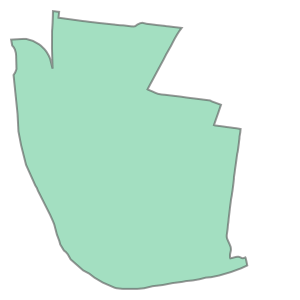

In [7]:
zone.loc[0, 'geometry']

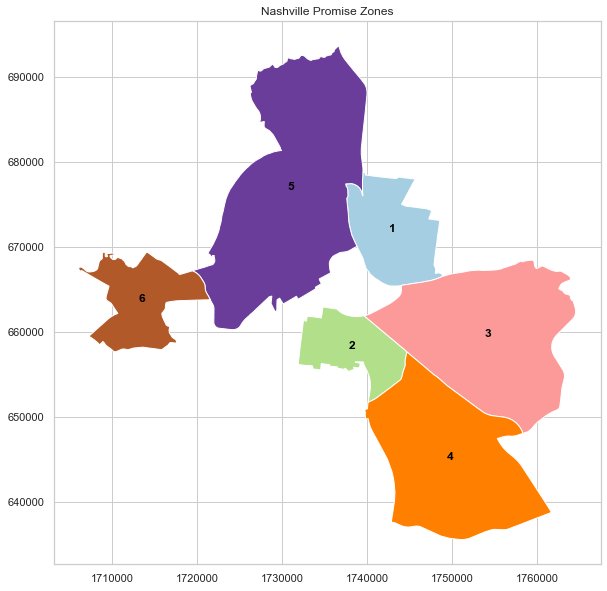

In [8]:
#Mapping and legend

#leg_kwds = {'title': 'Zone', 'loc': 'best', 
#            'bbox_to_anchor': (1, 1), 'ncol': 1}

#zone.plot(column = 'ZONE_ID', figsize=(12, 12), legend = True, legend_kwds = leg_kwds,cmap = 'Set2')
#plt.title('Nashville Promise Zones');
#plt.show()

fig, ax = plt.subplots(figsize = (10,10))
zone.plot(ax = ax, column = 'ZONE_ID', cmap = 'Paired')

for index, row in zone.iterrows():
    plt.annotate(s=row['ZONE_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight = 'bold', color = 'black')
    
plt.title('Nashville Promise Zones');

# Count of Companies in File

In [9]:
counts_may = may_trip_df['companyName'].value_counts()
print(counts_may)

Lime             102569
Lyft              54271
Bird              53496
SPIN               8471
Bolt Mobility      4912
Gotcha              650
JUMP                600
Name: companyName, dtype: int64


# Adding Geometry Columns

In [10]:
#Add StartGeometry Column
may_trip_df['startGeometry'] = may_trip_df.apply(lambda x: Point((float(x.startLongitude), float(x.startLatitude))), axis=1)
may_trip_df.head()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry
0,2019-05-01 00:00:55.423000,Bird,BRD2134,Powered9EAJL,3.0000,958.00528,2019-05-01 00:00:00,00:00:20.460000,2019-05-01 00:00:00,00:02:52.346666,36.15710,-86.80360,36.15660,-86.80670,"[[36.157235,-86.803612],[36.157235,-86.80362],...",2019-05-02 05:30:23.780000,POINT (-86.8036 36.1571)
1,2019-05-01 00:03:33.147000,Lyft,LFT5,Powered296631,1.7156,1371.39112,2019-05-01 00:00:00,00:01:50.090000,2019-05-01 00:00:00,00:03:33.026666,36.15797,-86.77896,36.16054,-86.77689,"[[36.15797,-86.77896],[36.15795,-86.77873],[36...",2019-05-02 07:20:32.757000,POINT (-86.77896 36.15797)
2,2019-05-01 00:05:55.570000,Bird,BRD2168,Powered7S2UU,3.0000,2296.58800,2019-05-01 00:00:00,00:03:47.363333,2019-05-01 00:00:00,00:07:13.596666,36.15470,-86.78180,36.15650,-86.78680,"[[36.155068,-86.782124],[36.156597,-86.78675]]",2019-05-02 05:30:24.530000,POINT (-86.7818 36.1547)
3,2019-05-01 00:05:55.570000,Bird,BRD2166,PoweredZIIVX,3.0000,1200.78744,2019-05-01 00:00:00,00:04:21.386666,2019-05-01 00:00:00,00:06:59.176666,36.14940,-86.77950,36.15310,-86.77960,"[[36.149741,-86.779344],[36.149741,-86.779327]...",2019-05-02 05:30:24.237000,POINT (-86.7795 36.1494)
4,2019-05-01 00:05:55.570000,Bird,BRD2165,PoweredJ7MB3,2.0000,351.04988,2019-05-01 00:00:00,00:04:27.796666,2019-05-01 00:00:00,00:06:23.150000,36.17780,-86.78660,36.17740,-86.78760,"[[36.177699,-86.786477],[36.177711,-86.786469]...",2019-05-02 05:30:24.207000,POINT (-86.78660000000001 36.1778)


In [11]:
#Add EndGeometry Column
may_trip_df['endGeometry'] = may_trip_df.apply(lambda x: Point((float(x.endLongitude), float(x.endLatitude))), axis=1)
may_trip_df.head()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
0,2019-05-01 00:00:55.423000,Bird,BRD2134,Powered9EAJL,3.0000,958.00528,2019-05-01 00:00:00,00:00:20.460000,2019-05-01 00:00:00,00:02:52.346666,36.15710,-86.80360,36.15660,-86.80670,"[[36.157235,-86.803612],[36.157235,-86.80362],...",2019-05-02 05:30:23.780000,POINT (-86.8036 36.1571),POINT (-86.80670000000001 36.1566)
1,2019-05-01 00:03:33.147000,Lyft,LFT5,Powered296631,1.7156,1371.39112,2019-05-01 00:00:00,00:01:50.090000,2019-05-01 00:00:00,00:03:33.026666,36.15797,-86.77896,36.16054,-86.77689,"[[36.15797,-86.77896],[36.15795,-86.77873],[36...",2019-05-02 07:20:32.757000,POINT (-86.77896 36.15797),POINT (-86.77688999999999 36.16054)
2,2019-05-01 00:05:55.570000,Bird,BRD2168,Powered7S2UU,3.0000,2296.58800,2019-05-01 00:00:00,00:03:47.363333,2019-05-01 00:00:00,00:07:13.596666,36.15470,-86.78180,36.15650,-86.78680,"[[36.155068,-86.782124],[36.156597,-86.78675]]",2019-05-02 05:30:24.530000,POINT (-86.7818 36.1547),POINT (-86.7868 36.1565)
3,2019-05-01 00:05:55.570000,Bird,BRD2166,PoweredZIIVX,3.0000,1200.78744,2019-05-01 00:00:00,00:04:21.386666,2019-05-01 00:00:00,00:06:59.176666,36.14940,-86.77950,36.15310,-86.77960,"[[36.149741,-86.779344],[36.149741,-86.779327]...",2019-05-02 05:30:24.237000,POINT (-86.7795 36.1494),POINT (-86.7796 36.1531)
4,2019-05-01 00:05:55.570000,Bird,BRD2165,PoweredJ7MB3,2.0000,351.04988,2019-05-01 00:00:00,00:04:27.796666,2019-05-01 00:00:00,00:06:23.150000,36.17780,-86.78660,36.17740,-86.78760,"[[36.177699,-86.786477],[36.177711,-86.786469]...",2019-05-02 05:30:24.207000,POINT (-86.78660000000001 36.1778),POINT (-86.7876 36.1774)


In [12]:
#CSR check
zone.crs


{'init': 'epsg:2274'}

** following code translated from the GeoSpacial class work 'WeGo Bus Stops by District'**

stops = may_trip_df
districts = promise zones

In [13]:
#Joinging two files to one

#original code: districs_stops = gpd.sjoin(stops_geo, districs, op = 'within')
#original code: district stops

#trip_zone = gpd.sjoin(trip_geo, zone, op = 'within')
#trip_zone

# Convert Time & Date Columns to datetime formats

In [14]:
#Convert to Dates
may_trip_df['startDate']=pd.to_datetime(may_trip_df.startDate)
may_trip_df['endDate']=pd.to_datetime(may_trip_df.endDate)
may_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224969 entries, 0 to 224968
Data columns (total 18 columns):
pubTimeStamp      224969 non-null object
companyName       224969 non-null object
tripRecordNum     224969 non-null object
sumdID            224969 non-null object
tripDuration      224969 non-null float64
tripDistance      224969 non-null float64
startDate         224969 non-null datetime64[ns]
startTime         224969 non-null object
endDate           224969 non-null datetime64[ns]
endTime           224969 non-null object
startLatitude     224969 non-null float64
startLongitude    224969 non-null float64
endLatitude       224969 non-null float64
endLongitude      224969 non-null float64
tripRoute         224969 non-null object
create_dt         224969 non-null object
startGeometry     224969 non-null object
endGeometry       224969 non-null object
dtypes: datetime64[ns](2), float64(6), object(10)
memory usage: 30.9+ MB


In [15]:
#Convert to Times
may_trip_df['startTime']=pd.to_datetime(may_trip_df.startTime)
may_trip_df['endTime']=pd.to_datetime(may_trip_df.endTime)
may_trip_df['pubTimeStamp']=pd.to_datetime(may_trip_df.pubTimeStamp)
may_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224969 entries, 0 to 224968
Data columns (total 18 columns):
pubTimeStamp      224969 non-null datetime64[ns]
companyName       224969 non-null object
tripRecordNum     224969 non-null object
sumdID            224969 non-null object
tripDuration      224969 non-null float64
tripDistance      224969 non-null float64
startDate         224969 non-null datetime64[ns]
startTime         224969 non-null datetime64[ns]
endDate           224969 non-null datetime64[ns]
endTime           224969 non-null datetime64[ns]
startLatitude     224969 non-null float64
startLongitude    224969 non-null float64
endLatitude       224969 non-null float64
endLongitude      224969 non-null float64
tripRoute         224969 non-null object
create_dt         224969 non-null object
startGeometry     224969 non-null object
endGeometry       224969 non-null object
dtypes: datetime64[ns](5), float64(6), object(7)
memory usage: 30.9+ MB


# Save File

In [16]:
#save to CSV
may_trip_df.to_csv('Data/may_trip_geo.csv', index = False)

# Stats based on Days of Week, Hours of Day

In [17]:
#Total Trips by Day
may_trips_day = may_trip_df.groupby(may_trip_df['startDate'].dt.dayofweek).count().startTime

print(may_trips_day)

startDate
0    27569
1    21658
2    24934
3    25714
4    40045
5    45381
6    39668
Name: startTime, dtype: int64


Text(0, 0.5, 'Number of rides')

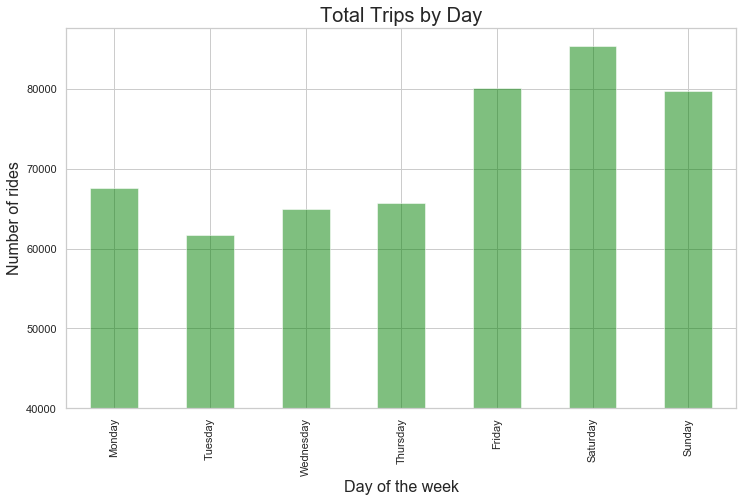

In [18]:
# Number of scooter per day of the week
may_trip_day = may_trip_df.groupby(may_trip_df['startDate'].dt.dayofweek).count().startDate

# Replace the day integers by day names.
may_trip_day.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
Img2 = may_trip_day.plot(kind='bar',figsize=(12,7), color='green', alpha=0.5, bottom = 40000)

# title and x,y labels
plt.title('Total Trips by Day', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of rides',fontsize=16)


Text(0, 0.5, 'Number of rides')

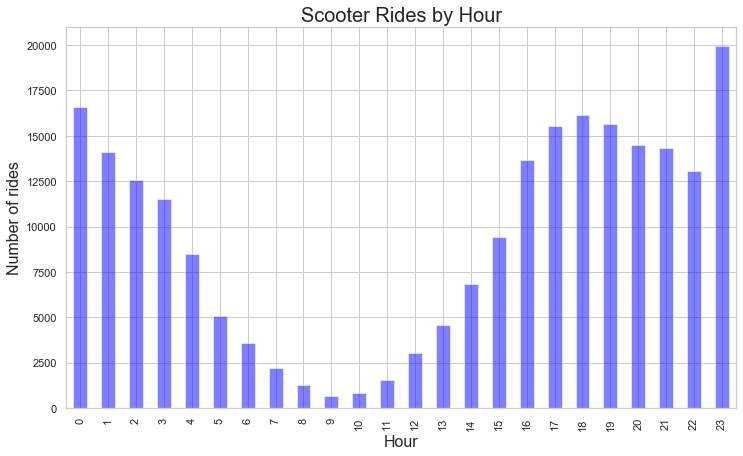

In [19]:
# Number of trips per hour
may_trip_hour = may_trip_df.groupby(may_trip_df['startTime'].dt.hour).count().startTime

# plot trips per hour
may_trip_hour.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5, bottom = 0)

# title and x,y labels
plt.title('Scooter Rides by Hour', fontsize=20)
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Number of rides',fontsize=16)



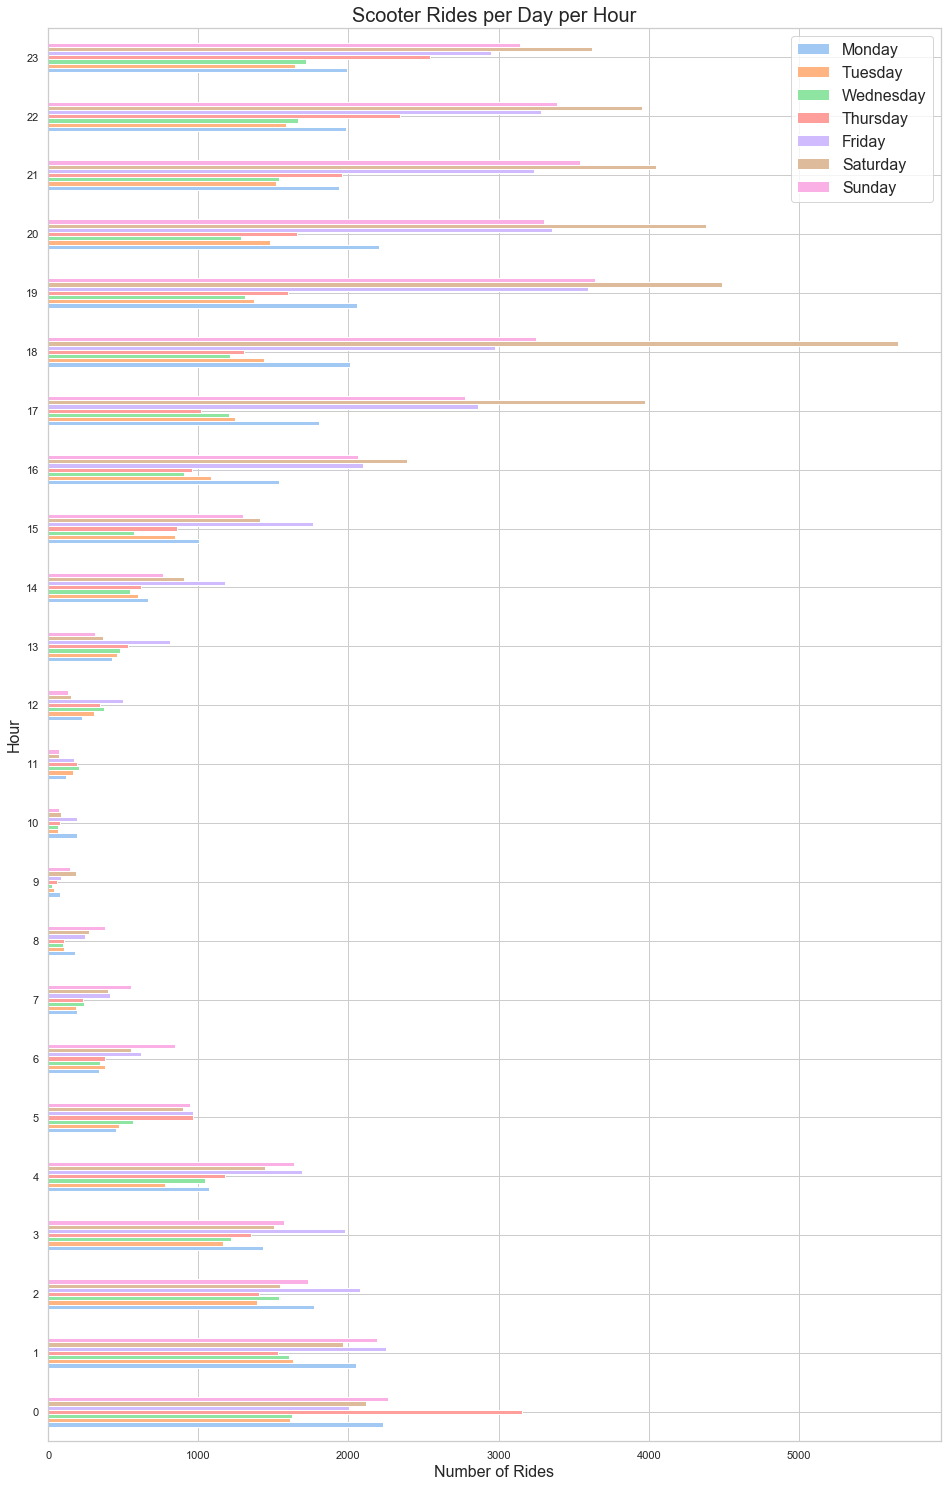

In [20]:
# Number of  Trips per hour and day
trips_hour_day = may_trip_df.groupby([may_trip_df['pubTimeStamp'].dt.hour.rename('hour'),may_trip_df['pubTimeStamp'].dt.dayofweek.rename('day')]).count().pubTimeStamp

trips_hour_day.unstack().plot(kind='barh', figsize=(16,26))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=16)
plt.title('Scooter Rides per Day per Hour',fontsize=20)
plt.xlabel('Number of Rides',fontsize=16)
plt.ylabel('Hour',fontsize=16);

# Number of Rides per Scooter

In [21]:
#Count of rides on each scooter
counts_scooters = may_trip_df['sumdID'].value_counts()
print(counts_scooters)

PoweredUNKNOWN                                 2166
Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2     600
PoweredWVIAXNCVDNOXP                            338
PoweredR3QXO6TL2HIAB                            291
PoweredRJ7YYJTHAR5N3                            274
PoweredEGRN7CFK6Q6K2                            261
PoweredDJQATZBXPBUAE                            254
PoweredLNAVSI3QKRPVH                            225
Powered75MFAMZCCD3QJ                            222
PoweredKCXMXKUIP3Z4E                            221
PoweredGVLQSJDAXWVPX                            200
Powered7F7SGZH42ZGS7                            196
Powered34ZSQ3V4KEPAS                            195
PoweredRRC5FV6DYYHBL                            193
Powered4FCVKYQ3DTH7H                            191
PoweredLABZO3C5YHDP4                            186
Powered4WOKR5XFN26KV                            185
Powered3XINKE5ALW66Z                            184
Powered3SDFC5NC4XZPZ                            180
PoweredJVORY

# Count Number of Rides per Day

In [22]:
#Count of rides on each scooter
counts_startDate = may_trip_df['startDate'].value_counts()
print(counts_startDate)

2019-05-26    14947
2019-05-25    14811
2019-05-18    12596
2019-05-04    10210
2019-05-27     9993
2019-05-19     9170
2019-05-17     9019
2019-05-24     8985
2019-05-05     8197
2019-05-31     7778
2019-05-11     7764
2019-05-03     7673
2019-05-12     7354
2019-05-10     6590
2019-05-06     6484
2019-05-16     6257
2019-05-20     5913
2019-05-07     5746
2019-05-28     5649
2019-05-23     5588
2019-05-08     5381
2019-05-14     5374
2019-05-30     5356
2019-05-15     5234
2019-05-13     5179
2019-05-22     5013
2019-05-21     4889
2019-05-29     4747
2019-05-01     4559
2019-05-02     4290
2019-05-09     4223
Name: startDate, dtype: int64


The busiest day of the month was 5/26/2019

In [23]:
#Subsetting 5/26/19 by Active Scooters

#day = (may_trip_df['startDate'] == '2019-05-26')
#busyday = may_trip_df.loc[day]
#busyday.head(2)

Several entries show trips where a beginning point and end point are the same. Due to this, trips without a change in geography will be considered inactive.

# Filtering DataFrame to Only Active Scooters 

In [24]:
active_df = may_trip_df

active_df['companyName'].value_counts()

Lime             102569
Lyft              54271
Bird              53496
SPIN               8471
Bolt Mobility      4912
Gotcha              650
JUMP                600
Name: companyName, dtype: int64

In [25]:
#populate the Low Rides df based on the a specified date
    
#for index, row in active_df.iterrows():
#    if row['startGeometry'] == row['endGeometry']:
#       active_df.drop(index, inplace=True)
    
#active_df.startgeometry.value_count()

In [61]:
#filter down to trips where distance was recorded
active_df = active_df[active_df.startGeometry != active_df.endGeometry]
active_df['companyName'].value_counts()

Lime             102210
Lyft              51936
Bird              49627
SPIN               8449
Bolt Mobility      3531
Gotcha              642
JUMP                584
Name: companyName, dtype: int64

# Filter the Active DataFrame to Those Traveled 3 Meters or More

In [27]:
#filter by Distance

#file provides distance in feet. 1 meter = 3.2 feet
#active_df = active_df[active_df.tripDistance >= 9.83]

In [28]:
#active_df.tail(1)

# Remove trips over 24 hrs

In [64]:
#filter previous list to those under 24 hour trips
active_lessTime = active_df[active_df.tripDuration <= 1440.0000]
active_lessTime['companyName'].value_counts()

Lime             102210
Lyft              51936
Bird              49627
SPIN               8449
Bolt Mobility      3531
Gotcha              642
JUMP                584
Name: companyName, dtype: int64

In [30]:
# Count of rides meeting 24hrs or less 
#counts_co1 = active_df['companyName'].value_counts()
#counts_co1

Lime             102210
Lyft              54039
Bird              49745
SPIN               8449
Bolt Mobility      3531
Gotcha              642
JUMP                584
Name: companyName, dtype: int64

# Remove trips under 1 minute

In [65]:
#filter previous list to those under 1 minute 
active_lessTime2 = active_df[active_df.tripDuration >= 1.0]
active_lessTime2['companyName'].value_counts()

Lime             102210
Lyft              51936
Bird              49627
SPIN               8449
Bolt Mobility      3531
Gotcha              642
JUMP                584
Name: companyName, dtype: int64

In [32]:
#counts_co2 = active_df['companyName'].value_counts()
#counts_co2

Lime             102210
Lyft              51936
Bird              49627
SPIN               8449
Bolt Mobility      3531
Gotcha              642
JUMP                584
Name: companyName, dtype: int64

# Filtering to Scooters w/ 90 trips per month (by DSpau)

In [33]:
Group1 = active_df.groupby(active_df.sumdID.tolist(),as_index=False).size()
print(Group1)

Powered-017d3133-f14a-2b83-ee4f-d777e7c5b619     13
Powered-01a24436-0315-e1bb-7ce0-d081d05dff7d     15
Powered-03be23ca-d43b-222f-be54-e44b5b4690df     16
Powered-046201fb-6532-1f37-6334-3612fb1e61f7      5
Powered-0479bb84-afbd-0426-f1c4-df628542a88c     11
Powered-0540c92c-0907-dafa-b19f-011495068ec5     11
Powered-0555d61d-1c59-4219-edf3-0f00e286629a     11
Powered-058d0498-dac4-437f-5a45-c951da4040a2     17
Powered-05fedb39-a00f-a5e0-2219-8c3c7dd1b80e     16
Powered-079ce993-98bd-417a-acfe-76e2861ebf9b      7
Powered-08505f68-1f44-5d79-48c5-1370977e40d5      5
Powered-09c75f98-6492-9d35-12e4-c5649cebf403     22
Powered-0ac70fa5-9f26-e69b-ca7a-9803d2aa1535      6
Powered-0b4a127c-3c2a-a917-cbf4-ccb17b8604f6     15
Powered-0cf6fb25-5afa-09e8-004a-aefd4e320266      1
Powered-0d5cbe57-9da1-9fad-e31c-4e33282a1efd      6
Powered-0e3d7343-0a27-2854-2dbc-23166bea8c8c     16
Powered-0e66b4be-c897-5140-f34c-b78d3beea648     15
Powered-0ef64718-9c36-353e-8bf0-39719364d924     13
Powered-0f34

In [34]:
Group1.to_csv('./Data/May_Active_Trip_Counter.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [35]:
col_Names=["sumdID", "Trips"]
Group1CSV= pd.read_csv("./Data/May_Active_Trip_Counter.csv",names=col_Names)

In [36]:
#Group1CSV

In [37]:
#filter to those over 90 trips
Trips_df = Group1CSV[Group1CSV.Trips >= 90]

In [38]:
Trips_df

,sumdID,Trips
835,Powered22FQFFGS7MJ2H,121
837,Powered22JP4HZ2Z3CGE,109
868,Powered23TSUHG3WSN3E,117
909,Powered25WTY4ODS5QZ7,115
919,Powered262DP6JF3EVJW,91
964,Powered27QVVV4F2MNCX,93
1022,Powered2B4I45S5OSI77,103
1023,Powered2BB4MPNHDD3QC,96
1034,Powered2GASLDZUJTRVL,102
1036,Powered2GUYGSBYPO75V,133


In [39]:
#Most Used Scooter:
A = Trips_df.Trips.max()
B = Trips_df.sumdID.max()

print(A)
print(B)

584
Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2


In [40]:
Most_Used = Trips_df[Trips_df.Trips == 564]
Most_Used

,sumdID,Trips


In [41]:
FilteredTrips = active_df[active_df['sumdID'].isin(Trips_df.sumdID)]
FilteredTrips

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
2218,2019-05-02 00:18:00.487,Lime,LIM2,PoweredOJFHQP5R57XW6,2.916667,0.0000,2019-05-01,2019-09-17 00:01:30,2019-05-01,2019-09-17 00:04:25,36.176972,-86.788644,36.182089,-86.792450,"[[36.17704,-86.78865]]",2019-05-03 06:43:26.303000,POINT (-86.78864400000001 36.176972),POINT (-86.79245 36.182089)
2220,2019-05-02 00:18:00.490,Lime,LIM6,PoweredGP3STF2M7IY5V,10.700000,280.7208,2019-05-01,2019-09-17 00:05:25,2019-05-01,2019-09-17 00:16:07,36.161776,-86.775156,36.156894,-86.765992,"[[36.16151,-86.77581],[36.16173,-86.77513],[36...",2019-05-03 06:43:26.437000,POINT (-86.775156 36.161776),POINT (-86.765992 36.156894)
2224,2019-05-02 00:18:00.493,Lime,LIM9,PoweredAHZXFQBLMHONL,8.216667,304.4952,2019-05-01,2019-09-17 00:08:30,2019-05-01,2019-09-17 00:16:43,36.147184,-86.804760,36.147282,-86.807418,"[[36.14777,-86.80632],[36.147040000000004,-86....",2019-05-03 06:43:26.537000,POINT (-86.80476 36.147184),POINT (-86.807418 36.147282)
2229,2019-05-02 00:18:00.497,Lime,LIM14,PoweredCCVEW5N6QKW2N,37.050000,2182.6728,2019-05-01,2019-09-17 00:13:02,2019-05-01,2019-09-17 00:50:05,36.133655,-86.798690,36.132595,-86.795829,"[[36.13341,-86.79845],[36.13478,-86.79845],[36...",2019-05-03 06:43:26.723000,POINT (-86.79868999999999 36.133655),POINT (-86.795829 36.132595)
2233,2019-05-02 00:18:00.500,Lime,LIM16,PoweredWVIAXNCVDNOXP,3.233333,52.4256,2019-05-01,2019-09-17 00:13:29,2019-05-01,2019-09-17 00:16:43,36.155838,-86.773700,36.155789,-86.773657,"[[36.15584,-86.7737],[36.15589,-86.77351],[36....",2019-05-03 06:43:26.803000,POINT (-86.77370000000001 36.155838),POINT (-86.773657 36.155789)
2234,2019-05-02 00:18:00.500,Lime,LIM19,PoweredOMYZ2DFOUTAC6,2.133333,127.1016,2019-05-01,2019-09-17 00:16:57,2019-05-01,2019-09-17 00:19:05,36.159013,-86.778345,36.156780,-86.780415,"[[36.15801,-86.77774],[36.158179999999994,-86....",2019-05-03 06:43:26.910000,POINT (-86.778345 36.159013),POINT (-86.780415 36.15678)
2235,2019-05-02 00:18:00.500,Lime,LIM20,PoweredRRC5FV6DYYHBL,11.900000,991.2096,2019-05-01,2019-09-17 00:17:04,2019-05-01,2019-09-17 00:28:58,36.149135,-86.800122,36.131960,-86.784047,"[[36.14856,-86.79985],[36.148520000000005,-86....",2019-05-03 06:43:26.943000,POINT (-86.800122 36.149135),POINT (-86.784047 36.13196)
2239,2019-05-02 00:18:00.503,Lime,LIM22,PoweredPGWNYTW66EXYN,2.050000,109.1184,2019-05-01,2019-09-17 00:18:14,2019-05-01,2019-09-17 00:20:17,36.157872,-86.781280,36.160108,-86.778679,"[[36.15753,-86.78108],[36.160090000000004,-86....",2019-05-03 06:43:27.010000,POINT (-86.78128 36.157872),POINT (-86.778679 36.160108)
2245,2019-05-02 00:18:00.507,Lime,LIM28,PoweredEHE6JC5MOQS75,1.733333,45.4152,2019-05-01,2019-09-17 00:26:29,2019-05-01,2019-09-17 00:28:13,36.142671,-86.792524,36.143100,-86.791804,"[[36.14262,-86.79249],[36.14266,-86.79248],[36...",2019-05-03 06:43:27.223000,POINT (-86.792524 36.142671),POINT (-86.791804 36.1431)
2246,2019-05-02 00:18:00.507,Lime,LIM29,PoweredIBDS7UHO725TX,3.900000,196.5960,2019-05-01,2019-09-17 00:27:40,2019-05-01,2019-09-17 00:31:34,36.157608,-86.774962,36.153924,-86.778278,"[[36.15812,-86.77425],[36.157549999999993,-86....",2019-05-03 06:43:27.263000,POINT (-86.774962 36.157608),POINT (-86.778278 36.153924)


In [42]:
counts_co1 = FilteredTrips['companyName'].value_counts()
print(counts_co1)

Lime    49023
JUMP      584
Name: companyName, dtype: int64


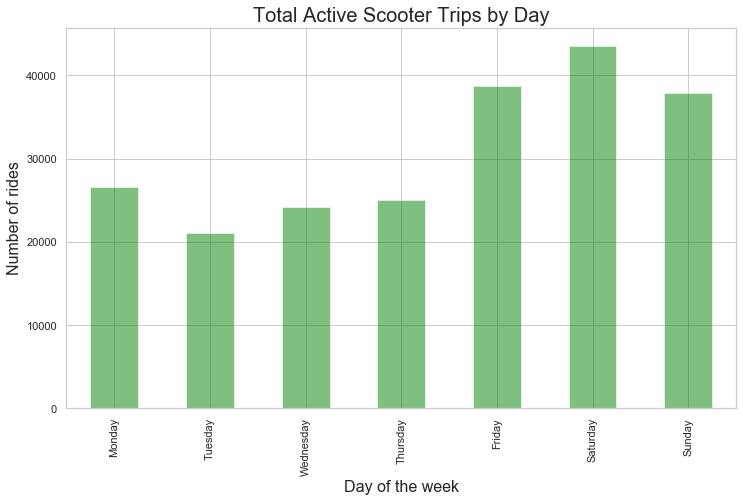

In [43]:
# Number of scooter per day of the week
may_active = active_df.groupby(active_df['startDate'].dt.dayofweek).count().startDate

# Replace the day integers by day names.
may_active.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
may_active.plot(kind='bar',figsize=(12,7), color='green', alpha=0.5, bottom = 0)

# title and x,y labels
plt.title('Total Active Scooter Trips by Day', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of rides',fontsize=16);

# JUMP Scooter w/ excessive rides data

In [44]:
#view JUMP scooter w/ 600 rides
JUMP_May = FilteredTrips[FilteredTrips.sumdID == 'Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2']
JUMP_May

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
100007,2019-05-17 10:31:57,JUMP,JMP425,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.735817,1161.6,2019-05-17,2019-09-17 05:44:32,2019-05-17,2019-09-17 05:50:16,36.167904,-86.782970,36.167953,-86.783110,"[[""36.16797"",""-86.782968""],[""36.167975"",""-86.7...",2019-05-18 06:20:19.380000,POINT (-86.78297000000001 36.167904),POINT (-86.78310999999999 36.167953)
100008,2019-05-17 10:31:57,JUMP,JMP382,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,17.605667,6969.6,2019-05-17,2019-09-17 04:33:39,2019-05-17,2019-09-17 04:51:16,36.161507,-86.775980,36.168410,-86.767180,"[[""36.161466"",""-86.775936""],[""36.161466"",""-86....",2019-05-18 06:20:17.900000,POINT (-86.77598 36.161507),POINT (-86.76718 36.16841)
100009,2019-05-17 10:31:57,JUMP,JMP391,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,3.145083,633.6,2019-05-17,2019-09-17 05:03:35,2019-05-17,2019-09-17 05:06:43,36.158195,-86.784030,36.158676,-86.782610,"[[""36.158383"",""-86.784003""],[""36.158096"",""-86....",2019-05-18 06:20:18.233000,POINT (-86.78403 36.158195),POINT (-86.78261000000001 36.158676)
100010,2019-05-17 10:31:57,JUMP,JMP461,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,2.921533,1108.8,2019-05-17,2019-09-17 07:26:38,2019-05-17,2019-09-17 07:29:34,36.163870,-86.774780,36.164394,-86.775670,"[[""36.16387"",""-86.774781""],[""36.16387"",""-86.77...",2019-05-18 06:20:35.663000,POINT (-86.77478000000001 36.16387),POINT (-86.77567000000001 36.164394)
100011,2019-05-17 10:31:57,JUMP,JMP415,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,25.616600,17054.4,2019-05-17,2019-09-17 05:11:18,2019-05-17,2019-09-17 05:36:55,36.157550,-86.792755,36.182472,-86.806590,"[[""36.157531"",""-86.792738""],[""36.157443"",""-86....",2019-05-18 06:20:18.973000,POINT (-86.792755 36.15755),POINT (-86.80659 36.182472)
100012,2019-05-17 10:31:57,JUMP,JMP452,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,11.141167,4488.0,2019-05-17,2019-09-17 06:56:04,2019-05-17,2019-09-17 07:07:13,36.176110,-86.792890,36.179626,-86.789230,"[[""36.17611"",""-86.792891""],[""36.17611"",""-86.79...",2019-05-18 06:20:20.213000,POINT (-86.79289 36.17611),POINT (-86.78923 36.179626)
100013,2019-05-17 10:31:57,JUMP,JMP443,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,9.738183,7867.2,2019-05-17,2019-09-17 06:29:08,2019-05-17,2019-09-17 06:38:53,36.161190,-86.777405,36.179653,-86.790825,"[[""36.161165"",""-86.777511""],[""36.161175"",""-86....",2019-05-18 06:20:20.023000,POINT (-86.777405 36.16119),POINT (-86.790825 36.179653)
100014,2019-05-17 10:31:57,JUMP,JMP384,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,25.911818,8184.0,2019-05-17,2019-09-17 04:28:51,2019-05-17,2019-09-17 04:54:46,36.137924,-86.805084,36.145424,-86.809710,"[[""36.137926"",""-86.805088""],[""36.137926"",""-86....",2019-05-18 06:20:18.040000,POINT (-86.80508399999999 36.137924),POINT (-86.80971 36.145424)
100015,2019-05-17 10:31:57,JUMP,JMP393,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,11.225650,7814.4,2019-05-17,2019-09-17 04:56:27,2019-05-17,2019-09-17 05:07:41,36.161230,-86.777534,36.145206,-86.784730,"[[""36.161365"",""-86.777686""],[""36.161186"",""-86....",2019-05-18 06:20:18.473000,POINT (-86.777534 36.16123),POINT (-86.78473 36.145206)
100016,2019-05-17 10:31:57,JUMP,JMP379,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.310083,1531.2,2019-05-17,2019-09-17 04:41:10,2019-05-17,2019-09-17 04:46:29,36.155620,-86.780850,36.154870,-86.776750,"[[""36.155621"",""-86.780855""],[""36.155628"",""-86....",2019-05-18 06:20:17.763000,POINT (-86.78085 36.15562),POINT (-86.77675000000001 36.15487)


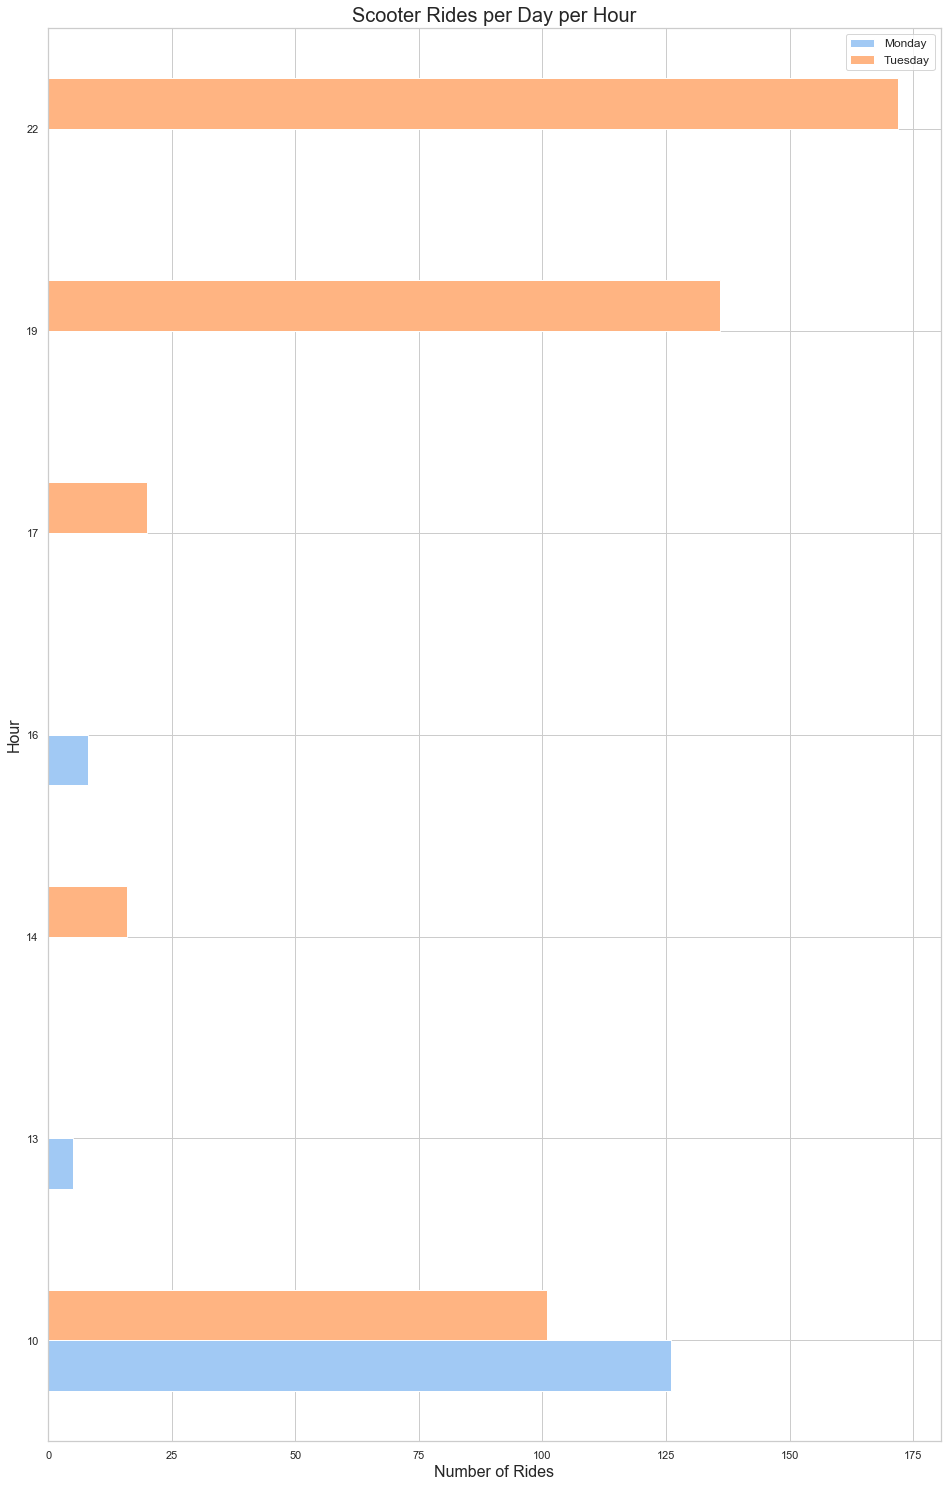

In [45]:
# Number of  Trips per hour and day - Jump Scooter
trips_hour_day1 = JUMP_May.groupby([JUMP_May['pubTimeStamp'].dt.hour.rename('hour'),JUMP_May['pubTimeStamp'].dt.dayofweek.rename('day')]).count().pubTimeStamp

trips_hour_day1.unstack().plot(kind='barh', figsize=(16,26))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=12)
plt.title('Scooter Rides per Day per Hour',fontsize=20)
plt.xlabel('Number of Rides',fontsize=16)
plt.ylabel('Hour',fontsize=16);

In [46]:
Rides = JUMP_May.groupby(JUMP_May['pubTimeStamp'].dt.date).count().pubTimeStamp
Rides

pubTimeStamp
2019-05-17    445
2019-05-20    139
Name: pubTimeStamp, dtype: int64

Text(0.5, 0, 'date')

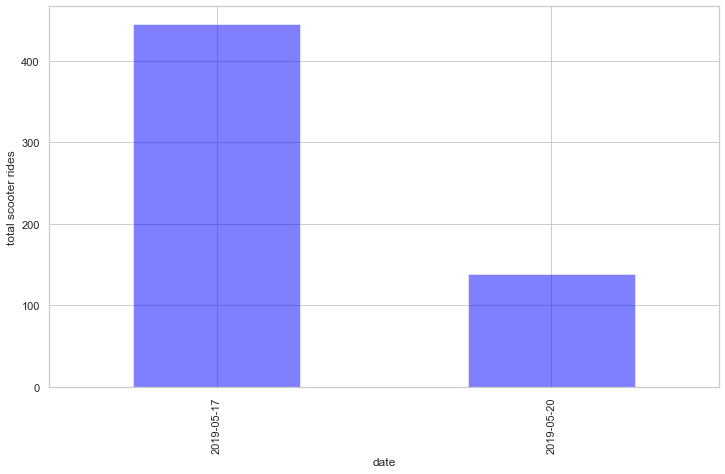

In [47]:
Rides.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)
plt.ylabel('total scooter rides', fontsize=12)
plt.xlabel ('date', fontsize=12)

In [48]:
JUMP_5_17 = JUMP_May[JUMP_May.startDate == '2019-05-17']


#save to CSV
JUMP_5_17.to_csv('Data/JUMP_May5_17.csv', index = False)

In [49]:
JUMP_5_17


,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
100007,2019-05-17 10:31:57,JUMP,JMP425,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.735817,1161.6,2019-05-17,2019-09-17 05:44:32,2019-05-17,2019-09-17 05:50:16,36.167904,-86.782970,36.167953,-86.783110,"[[""36.16797"",""-86.782968""],[""36.167975"",""-86.7...",2019-05-18 06:20:19.380000,POINT (-86.78297000000001 36.167904),POINT (-86.78310999999999 36.167953)
100008,2019-05-17 10:31:57,JUMP,JMP382,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,17.605667,6969.6,2019-05-17,2019-09-17 04:33:39,2019-05-17,2019-09-17 04:51:16,36.161507,-86.775980,36.168410,-86.767180,"[[""36.161466"",""-86.775936""],[""36.161466"",""-86....",2019-05-18 06:20:17.900000,POINT (-86.77598 36.161507),POINT (-86.76718 36.16841)
100009,2019-05-17 10:31:57,JUMP,JMP391,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,3.145083,633.6,2019-05-17,2019-09-17 05:03:35,2019-05-17,2019-09-17 05:06:43,36.158195,-86.784030,36.158676,-86.782610,"[[""36.158383"",""-86.784003""],[""36.158096"",""-86....",2019-05-18 06:20:18.233000,POINT (-86.78403 36.158195),POINT (-86.78261000000001 36.158676)
100010,2019-05-17 10:31:57,JUMP,JMP461,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,2.921533,1108.8,2019-05-17,2019-09-17 07:26:38,2019-05-17,2019-09-17 07:29:34,36.163870,-86.774780,36.164394,-86.775670,"[[""36.16387"",""-86.774781""],[""36.16387"",""-86.77...",2019-05-18 06:20:35.663000,POINT (-86.77478000000001 36.16387),POINT (-86.77567000000001 36.164394)
100011,2019-05-17 10:31:57,JUMP,JMP415,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,25.616600,17054.4,2019-05-17,2019-09-17 05:11:18,2019-05-17,2019-09-17 05:36:55,36.157550,-86.792755,36.182472,-86.806590,"[[""36.157531"",""-86.792738""],[""36.157443"",""-86....",2019-05-18 06:20:18.973000,POINT (-86.792755 36.15755),POINT (-86.80659 36.182472)
100012,2019-05-17 10:31:57,JUMP,JMP452,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,11.141167,4488.0,2019-05-17,2019-09-17 06:56:04,2019-05-17,2019-09-17 07:07:13,36.176110,-86.792890,36.179626,-86.789230,"[[""36.17611"",""-86.792891""],[""36.17611"",""-86.79...",2019-05-18 06:20:20.213000,POINT (-86.79289 36.17611),POINT (-86.78923 36.179626)
100013,2019-05-17 10:31:57,JUMP,JMP443,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,9.738183,7867.2,2019-05-17,2019-09-17 06:29:08,2019-05-17,2019-09-17 06:38:53,36.161190,-86.777405,36.179653,-86.790825,"[[""36.161165"",""-86.777511""],[""36.161175"",""-86....",2019-05-18 06:20:20.023000,POINT (-86.777405 36.16119),POINT (-86.790825 36.179653)
100014,2019-05-17 10:31:57,JUMP,JMP384,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,25.911818,8184.0,2019-05-17,2019-09-17 04:28:51,2019-05-17,2019-09-17 04:54:46,36.137924,-86.805084,36.145424,-86.809710,"[[""36.137926"",""-86.805088""],[""36.137926"",""-86....",2019-05-18 06:20:18.040000,POINT (-86.80508399999999 36.137924),POINT (-86.80971 36.145424)
100015,2019-05-17 10:31:57,JUMP,JMP393,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,11.225650,7814.4,2019-05-17,2019-09-17 04:56:27,2019-05-17,2019-09-17 05:07:41,36.161230,-86.777534,36.145206,-86.784730,"[[""36.161365"",""-86.777686""],[""36.161186"",""-86....",2019-05-18 06:20:18.473000,POINT (-86.777534 36.16123),POINT (-86.78473 36.145206)
100016,2019-05-17 10:31:57,JUMP,JMP379,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.310083,1531.2,2019-05-17,2019-09-17 04:41:10,2019-05-17,2019-09-17 04:46:29,36.155620,-86.780850,36.154870,-86.776750,"[[""36.155621"",""-86.780855""],[""36.155628"",""-86....",2019-05-18 06:20:17.763000,POINT (-86.78085 36.15562),POINT (-86.77675000000001 36.15487)


In [50]:
JUMP_5_17 = JUMP_May[JUMP_May.startDate == '2019-05-17']

In [51]:
JUMP_May.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 100007 to 133632
Data columns (total 18 columns):
pubTimeStamp      584 non-null datetime64[ns]
companyName       584 non-null object
tripRecordNum     584 non-null object
sumdID            584 non-null object
tripDuration      584 non-null float64
tripDistance      584 non-null float64
startDate         584 non-null datetime64[ns]
startTime         584 non-null datetime64[ns]
endDate           584 non-null datetime64[ns]
endTime           584 non-null datetime64[ns]
startLatitude     584 non-null float64
startLongitude    584 non-null float64
endLatitude       584 non-null float64
endLongitude      584 non-null float64
tripRoute         584 non-null object
create_dt         584 non-null object
startGeometry     584 non-null object
endGeometry       584 non-null object
dtypes: datetime64[ns](5), float64(6), object(7)
memory usage: 86.7+ KB


# Subsetting to specific time frame

In [52]:
#Jump_Time = JUMP_5_17[(JUMP_5_17.startTime >= '2019-09-12 04:00:00') & (JUMP_5_17.startTime <= '2019-09-12 04:15:00')]
#Jump_Time['geo'] = JUMP_5_17.apply(lambda x: list((float(x.startLatitude), float(x.startLongitude))), axis=1)
#for i in Jump_Time['geo']:
 #   print(i[0], i[1])

In [53]:
#Jump_Time
#starts = Jump_Time


In [54]:
#locations = starts[['startLatitude', 'startLongitude']]
#locationlist = locations.values.tolist()
#len(locationlist)
#locationlist[1]

In [55]:
#nashv_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)
#for point in range(0, len(locationlist)):
 #   folium.Marker(locationlist[point], popup=starts['sumdID'][point]).add_to(nashv_map)
#nashv_map

# Mapping

In [56]:
#create our map of Antioch and show it
#map_nash = folium.Map(location=[36.174465, -86.767960], zoom_start=12)
#map_nash

In [57]:

#JUMP = gpd.GeoDataFrame(Jump_Time, geometry = 'startGeometry')


#JUMPS.to_file("./Data/JUMP_5_17.geojson", driver='GeoJSON')

In [58]:
#for geo in Jump_Time['geo']:
#   folium.features.Circle([geo[1], geo[0]], radius=4, color='darkslateblue', opacity=0.5).add_to(map_nash)

#map_nash

In [59]:
#draw our neighborhood: Urban Residents

#nashville_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)

#folium.GeoJson(JUMP[['startGeometry']].to_json())

#points = folium.features.GeoJson(JUMP[['startGeometry']].to_json())
#ends = folium.features.GeoJson(JUMPS[['endGeometry']].to_json())
#
#nashville_map.add_child(points) 

#nashville_map


nashville_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)


for geo in Jump_Time['geo']:
    folium.features.Circle([geo[1], geo[0]],
                               radius=4,
                               color='darkslateblue',
                               opacity=0.5
                               ).add_to(nashville_map)


nashville_map

# Spare Code

In [60]:
may_trip_df.companyName.values_count()

AttributeError: 'Series' object has no attribute 'values_count'

HeatMap code:

Nashville_map = folium.Map(location=[36.1619178,-86.8213942], zoom_start=12)

hour_list = [[] for _ in range(24)]
for lat,log,hour in zip(bolt_may_df.latitude,bolt_may_df.longitude,bolt_may_df.pubdatetime.dt.hour):
    hour_list[hour].append([lat,log]) 


index = [str(i)+' Hours' for i in range(24)]


HeatMapWithTime(hour_list, index).add_to(Nashville_map)

Nashville_map